In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import uuid
import cvxpy as cp

# Set random seed for reproducibility
np.random.seed(42)

In [37]:
# Step 1: Define System and Simulation Parameters
N = 64  # Number of BS antennas
K = 4   # Number of users
M = 4   # Number of RF chains
omega = 0.3  # Tradeoff weight

I_max = 60  # Maximum outer iterations
J_values = [10, 20]  # Inner iteration counts
SNR_dB = 12  # SNR in dB
sigma_n2 = 1  # Noise variance
P_BS = sigma_n2 * 10**(SNR_dB / 10)  # Transmit power
mu = 0.01  # Step size for analog precoder
lambda_ = 0.01  # Step size for digital precoder
L = 20  # Number of paths for channel
num_realizations = 2  # Number of channel realizations

In [38]:
# Step 2: Define Sensing Parameters
P = 3  # Number of desired sensing angles
theta_d = np.array([-60, 0, 60]) * np.pi / 180  # Desired angles in radians
delta_theta = 5 * np.pi / 180  # Half beamwidth
theta_grid = np.linspace(-np.pi / 2, np.pi / 2, 181)  # Angular grid [-90, 90] degrees
B_d = np.zeros(len(theta_grid))  # Desired beampattern
for t, theta_t in enumerate(theta_grid):
    for theta_p in theta_d:
        if abs(theta_t - theta_p) <= delta_theta:
            B_d[t] = 1

# Wavenumber and antenna spacing
lambda_wave = 1  # Wavelength (normalized)
k = 2 * np.pi / lambda_wave
d = lambda_wave / 2  # Antenna spacing

In [39]:
# Step 3: Channel Matrix Generation (Saleh-Valenzuela Model)
def generate_channel(N, M, L):
    H = np.zeros((M, N), dtype=complex)
    for _ in range(L):
        alpha = np.random.normal(0, 1, 2).view(complex)[0] / np.sqrt(2)  # Complex gain
        phi_r = np.random.uniform(0, 2 * np.pi)  # Angle of arrival
        phi_t = np.random.uniform(0, 2 * np.pi)  # Angle of departure
        a_r = np.exp(1j * k * d * np.arange(M) * np.sin(phi_r)) / np.sqrt(M)
        a_t = np.exp(1j * k * d * np.arange(N) * np.sin(phi_t)) / np.sqrt(N)
        H += np.sqrt(N * M / L) * alpha * np.outer(a_r, a_t.conj())
    return H

# Steering vector function
def steering_vector(theta, N):
    return np.exp(1j * k * d * np.arange(N) * np.sin(theta)) / np.sqrt(N)

# Compute benchmark covariance matrix Psi
def compute_psi(N, theta_grid, B_d):

    T = len(theta_grid)
    
    # Build steering matrix
    A_theta = np.array([steering_vector(theta, N) for theta in theta_grid]).T  # N x T

    # Step 1: Approximate Psi via weighted sum of projectors
    Psi = np.zeros((N, N), dtype=complex)
    for t in range(T):
        a_t = A_theta[:, t]
        Psi += B_d[t] * np.outer(a_t, a_t.conj())

    # Step 2: Normalize with respect to total power constraint
    Psi /= np.trace(Psi) / P_BS

    # Step 3: Enforce Hermitian property
    Psi = (Psi + Psi.conj().T) / 2

    # Step 4: Enforce equal power per antenna (diagonal constraint)
    np.fill_diagonal(Psi, P_BS / N)

    # Step 5: Ensure positive semi-definiteness (project small negative eigenvalues)
    eigvals, eigvecs = np.linalg.eigh(Psi)
    eigvals = np.maximum(eigvals, 0)
    Psi = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T

    return Psi

Psi = compute_psi(N, theta_grid, B_d)

# Compute communication rate R
def compute_rate(H, A, D, sigma_n2):
    H_A = H @ A  # Effective channel
    R = 0
    for k in range(K):
        h_k = H_A[:, k]
        signal = np.abs(h_k.conj().T @ D[:, k])**2
        interference = sum(np.abs(h_k.conj().T @ D[:, j])**2 for j in range(K) if j != k)
        SINR = signal / (interference + sigma_n2)
        R += np.log2(1 + SINR)
    return R

# Compute sensing error tau
def compute_tau(A, D, Psi, theta_grid):
    V = A @ D
    tau = 0
    for theta in theta_grid:
        a_theta = steering_vector(theta, N)
        tau += np.abs(a_theta.conj().T @ V @ V.conj().T @ a_theta - a_theta.conj().T @ Psi @ a_theta)**2
    return tau / len(theta_grid)

def gradient_R_A(H, A, D, sigma_n2):
    xi = 1 / np.log(2)
    grad_A = np.zeros_like(A, dtype=complex)

    # Effective covariance of the digital precoder
    V = D @ D.conj().T

    for k in range(K):
        # User-k effective channel outer product
        h_k = H[k, :].reshape(-1, 1)  # (M x 1)
        H_tilde_k = h_k @ h_k.conj().T

        # D_bar_k = D with user k's column set to zero
        D_bar_k = D.copy()
        D_bar_k[:, k] = 0.0

        V_bar_k = D_bar_k @ D_bar_k.conj().T

        # Denominator terms (trace parts) — fixed
        denom1 = np.trace(A @ V @ A.conj().T @ H_tilde_k) + sigma_n2
        denom2 = np.trace(A @ V_bar_k @ A.conj().T @ H_tilde_k) + sigma_n2

        # Gradient contribution
        term1 = H_tilde_k @ A @ V / denom1
        term2 = H_tilde_k @ A @ V_bar_k / denom2

        grad_A += xi * (term1 - term2)

    return grad_A

def gradient_R_D(H, A, D, sigma_n2):
    xi = 1 / np.log(2)            # Conversion factor from ln() to log2()
    grad_D = np.zeros_like(D, dtype=complex)

    # --- Loop over users k ---
    for k in range(K):
        # (1) Channel vector for user k
        h_k = H[k, :].reshape(-1, 1)             # (N x 1)
        H_tilde_k = h_k @ h_k.conj().T           # (N x N)

        # (2) Effective digital-domain channel including analog precoder
        H_bar_k = A.conj().T @ H_tilde_k @ A     # (M x M)

        # (3) D_bar_k = D with k-th column set to zero
        D_bar_k = D.copy()
        D_bar_k[:, k] = 0.0

        # (4) Compute denominator terms (trace parts)
        denom1 = np.trace(D @ D.conj().T @ H_bar_k) + sigma_n2
        denom2 = np.trace(D_bar_k @ D_bar_k.conj().T @ H_bar_k) + sigma_n2

        # (5) Compute gradient contributions
        term1 = (H_bar_k @ D) / denom1
        term2 = (H_bar_k @ D_bar_k) / denom2

        # (6) Accumulate total gradient
        grad_D += xi * (term1 - term2)

    return grad_D


def gradient_tau_A(A, D, Psi):
    U = A @ D @ D.conj().T @ A.conj().T   # A D Dᴴ Aᴴ
    grad_A = 2 * (U - Psi) @ A @ D @ D.conj().T
    return grad_A


def gradient_tau_D(A, D, Psi):
    U = A @ D @ D.conj().T @ A.conj().T   # A D Dᴴ Aᴴ
    grad_D = 2 * A.conj().T @ (U - Psi) @ A @ D
    return grad_D



In [40]:

# Step 4: Initialization Strategies
def proposed_initialization(H, theta_d, N, M, K, P_BS):
    G = np.array([H[k, :] for k in range(K)]).T  # N x K
    A0 = np.exp(-1j * np.angle(G))[:, :M]
    X_ZF = np.linalg.pinv(H)
    D0 = np.linalg.pinv(A0) @ X_ZF
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')
    return A0, D0

def random_initialization(N, M, H, P_BS):
    A0 = np.exp(1j * np.random.uniform(0, 2 * np.pi, (N, M)))
    D0 = np.linalg.pinv(H @ A0)
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')
    return A0, D0

def svd_initialization(H, N, M, K, P_BS):
    _, _, Vh = svd(H, full_matrices=False)  # Vh is N x M (conjugate of right singular vectors)
    A0 = Vh.T[:, :M]  # Take first M columns, shape N x M
    A0 = np.exp(1j * np.angle(A0))  # Project to unit modulus
    H_A = H @ A0  # Shape: M x M
    try:
        D0 = np.linalg.pinv(H_A)  # Pseudoinverse of H @ A0
    except np.linalg.LinAlgError:
        D0 = np.linalg.pinv(H_A + 1e-6 * np.eye(M))  # Regularization for stability
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')  # Normalize
    return A0, D0

In [41]:
def run_pga(H, A0, D0, J, I_max, mu, lambda_, omega, sigma_n2, Psi, theta_grid):
    N, K = H.shape
    A = A0.copy()
    D = D0.copy()
    objectives = []
    eta = 1 / N  # Balancing term for gradient magnitudes

    for i in range(I_max):
        print(f"\n===== Outer Iteration {i+1}/{I_max} =====")

        # ---- Inner Loop: Analog Precoder Update ----
        A_hat = A.copy()
        for j in range(J):
            grad_R_A = gradient_R_A(H, A_hat, D, sigma_n2)
            grad_tau_A = gradient_tau_A(A_hat, D, Psi)

            # Eq. (14b): Gradient Ascent on A
            grad_A = grad_R_A - omega * grad_tau_A
            A_hat = A_hat + mu * grad_A

            # Eq. (7): Unit Modulus Projection
            A_hat = np.exp(1j * np.angle(A_hat))

        A = A_hat.copy()  # Set final A after J inner updates

        # ---- Outer Loop: Digital Precoder Update ----
        grad_R_D = gradient_R_D(H, A, D, sigma_n2)
        grad_tau_D = gradient_tau_D(A, D, Psi)

        # Eq. (15): Gradient Ascent on D
        grad_D = grad_R_D - omega * eta * grad_tau_D
        D = D + lambda_ * grad_D

        # Eq. (9): Power Constraint Projection
        D = P_BS * D / np.linalg.norm(A @ D, 'fro')

        # ---- Compute Objective (Eq. 5a) ----
        R = compute_rate(H, A, D, sigma_n2)
        tau = compute_tau(A, D, Psi, theta_grid)
        objective = R - omega * tau
        objectives.append(objective)

        print(f"Iteration {i+1}: R = {R:.4f}, τ = {tau:.4e}, Objective = {objective:.4f}")

    return objectives



===== Outer Iteration 1/60 =====
Iteration 1: R = 2.1160, τ = 2.2691e+01, Objective = -4.6913

===== Outer Iteration 2/60 =====
Iteration 2: R = 1.8824, τ = 2.3539e+01, Objective = -5.1792

===== Outer Iteration 3/60 =====
Iteration 3: R = 1.6848, τ = 2.4259e+01, Objective = -5.5930

===== Outer Iteration 4/60 =====
Iteration 4: R = 1.6683, τ = 2.4577e+01, Objective = -5.7047

===== Outer Iteration 5/60 =====
Iteration 5: R = 2.1179, τ = 2.2815e+01, Objective = -4.7267

===== Outer Iteration 6/60 =====
Iteration 6: R = 1.8064, τ = 2.7239e+01, Objective = -6.3653

===== Outer Iteration 7/60 =====
Iteration 7: R = 1.8033, τ = 2.6893e+01, Objective = -6.2647

===== Outer Iteration 8/60 =====
Iteration 8: R = 2.1411, τ = 3.4418e+01, Objective = -8.1842

===== Outer Iteration 9/60 =====
Iteration 9: R = 1.7787, τ = 3.3094e+01, Objective = -8.1495

===== Outer Iteration 10/60 =====
Iteration 10: R = 1.7835, τ = 3.2525e+01, Objective = -7.9741

===== Outer Iteration 11/60 =====
Iteration 11:

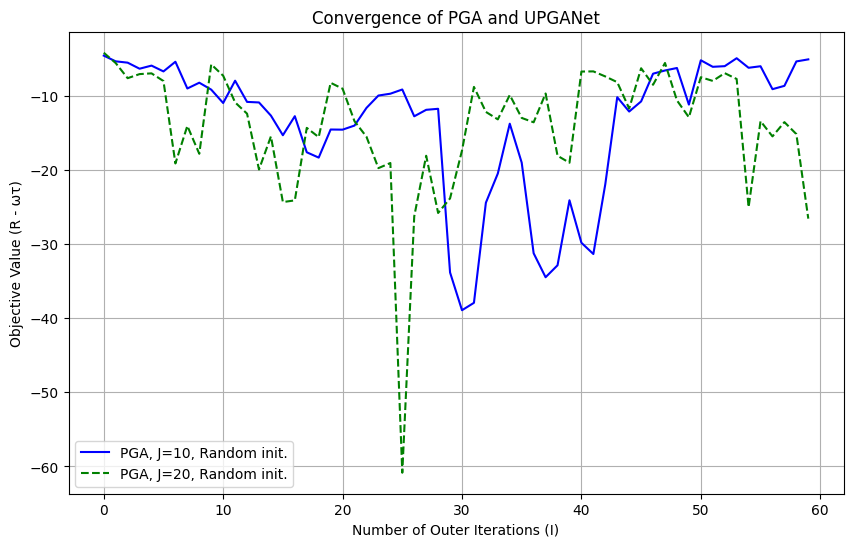

In [ ]:
# Step 6: Generate Plot
results = {
    'PGA_J10_Random': [],
    'PGA_J10_SVD': [],
    'PGA_J10_Proposed': [],
    'PGA_J20_Random': [],
    'PGA_J20_SVD': [],
    'PGA_J20_Proposed': [],
    'UPGANet_J10_Proposed': [],
    'UPGANet_J20_Proposed': []
}

for _ in range(num_realizations):
    H = generate_channel(N, M, L)
    for J in J_values:
        # Random Initialization
        A0, D0 = random_initialization(N, M, H, P_BS)
        objectives = run_pga(H, A0, D0, J, I_max, mu, lambda_, omega, sigma_n2, Psi, theta_grid)
        results[f'PGA_J{J}_Random'].append(objectives)
        print(f"Completed PGA with J={J} using Random Initialization")
        
        # SVD Initialization
        A0, D0 = svd_initialization(H, N, M, K, P_BS)
        objectives = run_pga(H, A0, D0, J, I_max, mu, lambda_, omega, sigma_n2, Psi, theta_grid)
        results[f'PGA_J{J}_SVD'].append(objectives)
        print(f"Completed PGA with J={J} using SVD Initialization")

        
        # Proposed Initialization
        A0, D0 = proposed_initialization(H, theta_d, N, M, K, P_BS)
        objectives = run_pga(H, A0, D0, J, I_max, mu, lambda_, omega, sigma_n2, Psi, theta_grid)
        results[f'PGA_J{J}_Proposed'].append(objectives)
        print(f"Completed PGA with J={J} using Proposed Initialization")
        
        # UPGANet (simulated with fixed step sizes)
        objectives = run_pga(H, A0, D0, J, I_max, mu * 1.5, lambda_ * 1.5, omega, sigma_n2, Psi, theta_grid)
        results[f'UPGANet_J{J}_Proposed'].append(objectives)
        print(f"Completed UPGANet simulation with J={J} using Proposed Initialization")

# Average results
avg_results = {key: np.mean(np.array(val), axis=0) for key, val in results.items()}

# Plotting
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
labels = [
    'PGA, J=10, Random init.',
    'PGA, J=10, SVD init.',
    'PGA, J=10, Proposed init.',
    'PGA, J=20, Random init.',
    'PGA, J=20, SVD init.',
    'PGA, J=20, Proposed init.',
    'UPGANet, J=10, Proposed init.',
    'UPGANet, J=20, Proposed init.'
]
for idx, (key, data) in enumerate(avg_results.items()):
    plt.plot(range(I_max), data, color=colors[idx], linestyle=styles[idx], label=labels[idx])
plt.xlabel('Number of Outer Iterations (I)')
plt.ylabel('Objective Value (R - ωτ)')
plt.title('Convergence of PGA and UPGANet')
plt.legend()
plt.grid(True)
plt.show()